In [1]:
import xarray as xr
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
module_path = '/home/jupyter-ayoub'
if module_path not in sys.path:
    sys.path.append(module_path)
from Transformer import StackedTransformer

In [3]:
#w100
test_rfcs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/TEST/test_observation.nc")

In [4]:
test_rfcs=test_rfcs
obs=obs

In [5]:
target='w100_obs'  
obs=obs[target]
test_rfcs=test_rfcs.drop_vars(['sd', 'mx2t6', 'mn2t6'])
#['sd', 'mx2t6', 'mn2t6', 'q', 'tp6', 'ssr6', 'str6', 'ssrd6', 'strd6']

In [6]:
#add orography as a variable
oro=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/oro.nc") 
dims={'time' : test_rfcs['time'],
       'number': test_rfcs['number'],
       'step': test_rfcs['step']}
xds_oro=oro.expand_dims(time=dims['time'], number=dims['number'],step=dims['step'])
dummy_oro=xr.Dataset(coords=dims)
final_oro=xds_oro.broadcast_like(dummy_oro)

In [7]:
fcs_10=xr.merge([test_rfcs,final_oro])
dummy=xr.merge([test_rfcs,final_oro])

In [8]:
#normalizing met oro.nc
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800),"ssr6":(0,3200000),"ssrd6":(-5200.0,18541902.0),"strd6":(2103856,9537712),"tp6":(-4,1),"ssr6":(-4220.0,15344816.0),"str6":(-4630656.0,1093968.0)}
# Function to normalize using vectorized operations
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds

def z_normalize(ds):
    for var in ds.data_vars:
        ds[var] = ds[var].copy()  # Ensure the variable is writable
        
        for t in range(len(ds["time"])):  # Loop over time dimension
            mean = ds[var].isel(time=t).mean()
            std = ds[var].isel(time=t).std()
            ds[var].loc[dict(time=ds["time"][t])] = (ds[var].isel(time=t) - mean) / std

    return ds



dummy_norm=minmax_normalize(dummy,min_max_values)
fcs_norm=dummy_norm

In [9]:
%reload_ext autoreload
model =  StackedTransformer(num_blocks=4, n_data_shape=(20, 32, 33, 15), n_heads=8,mlp_mult=4,projection_channels=64)

In [10]:
#this is where the last run is stored 
checkpoint_path = '/home/jupyter-ayoub/results/Transformerweights/w100/epochs50predictors15CRPSKERNELSTEPlambda0.02k3.3.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model_state_dict = checkpoint['model']
new_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1551969


In [11]:
#turn the normalized reforecasts into a tensor
fcs_norm_whole= fcs_norm.to_array(dim='variable')
print(fcs_norm_whole.sizes)
#print(fcs_norm_whole)
print(fcs_norm_whole.shape)
rearranged_10= fcs_norm_whole.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_tensor=torch.tensor(rearranged_10.values)
print(fcs_whole_tensor.shape) 

Frozen({'variable': 15, 'time': 209, 'number': 11, 'step': 20, 'latitude': 32, 'longitude': 33})
(15, 209, 11, 20, 32, 33)
torch.Size([209, 11, 20, 32, 33, 15])


In [12]:
#same for unnormalized data, because I need them for the rescaling 
fcs_array_10 =fcs_10.to_array(dim='variable')
fcs_rearranged_10= fcs_array_10.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_notnorm_tensor=torch.tensor(fcs_rearranged_10.values)
print(fcs_whole_notnorm_tensor.shape)

torch.Size([209, 11, 20, 32, 33, 15])


In [13]:
MBM_one=np.empty((209,11,20,32,33),dtype=float)
for i in range(20):
    mbm1=np.load(f"/home/jupyter-ayoub/ClassicalMBM/resultsClassicalMBM/{target}/MBM_{target}_{i}.npy")
    MBM_one[:,:,i,:,:]=mbm1.squeeze()

In [14]:
postpro_10_whole = torch.empty((209,11,20,32,33,1))

# Apply model in chunks of 10
with torch.no_grad():
    for i in range(0, 209, 2):
        # Get the end index for this chunk
        end = min(i + 2, 209)  # Ensure we don't go out of bounds

        # Apply the model to the chunk and store in the corresponding location in postpro_10_whole
        #print(fcs_whole_tensor[i:end].shape)
        #print(postpro_10_whole[i:end].shape)
        postpro_10_whole[i:end] = model(fcs_whole_tensor[i:end])

In [15]:
# Extract ensemble forecasts
ensemble_one = postpro_10_whole[...,0]

# Compute standard deviation & mean across ensemble dimension (dim=1)
scale_std, scale_mean = torch.std_mean(fcs_whole_notnorm_tensor[..., 8], dim=1, unbiased=True)

# Function to scale and clamp ensemble data
def scale_and_clamp(ensemble):
    scaled = ensemble * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)
    return torch.clamp(scaled, min=1e-6).permute(1, 0, 2, 3, 4)

# Apply scaling and clamping
scaled_ensemble_one = scale_and_clamp(ensemble_one)

In [16]:
# Define coordinates with member first
coords_forecast = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}


# Define dimensions with member first
dims_forecast = ('member', 'time', 'step', 'latitude', 'longitude')

# Convert numpy arrays to xarray DataArray with the specified order
MBM_one=xr.DataArray(np.transpose(MBM_one,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
full_ensemble_one= xr.DataArray(scaled_ensemble_one, coords=coords_forecast, dims=dims_forecast)

# Compute mean and std across the member dimension
mean_one = full_ensemble_one.mean(dim='member')
std_one = full_ensemble_one.std(dim='member')

# Adjust raw_fcs to have 'member' first
raw_fcs = test_rfcs.rename({'number': 'member'})
raw_fcs = raw_fcs.transpose('member', 'time', 'step', 'latitude', 'longitude')
raw_mean=raw_fcs.mean(dim='member')
raw_std=raw_fcs.std(dim='member')

In [17]:
#ALL ENSEMBLES
Tformer_one=full_ensemble_one
MBM_one = MBM_one
Raw = raw_fcs['w100']

In [18]:
import torch

def wind_speed_to_power(
    wind_speed: torch.Tensor,
    p_rated: float = 1.0,
    v_cut_in: float = 3.0,
    v_rated: float = 11.0,
    v_cut_out: float = 25.0
) -> torch.Tensor:
    """
    De paper "Current-Day and Future Dunkelflaute Risks for Belgium",
    sectie 2. Data and Methods, onder c. Power Production Time Series, staat een beschrijving van het gebruikte windvermogenmodel.
    stukgewijze benadering gebruiken op basis van de windturbinevermogenkarakteristiek.
    
    Zet windsnelheid (in m/s) om naar vermogen (in arbitrary units, schaalbaar met p_rated).
    
    Parameters:
    - wind_speed (torch.Tensor): Windsnelheden in m/s.
    - p_rated (float): Nominaal vermogen (default = 1.0; schaalbaar per turbine/installatie).
    - v_cut_in (float): Cut-in windsnelheid (default = 3.0 m/s).
    - v_rated (float): Nominale windsnelheid (default = 11.0 m/s).
    - v_cut_out (float): Cut-out windsnelheid (default = 25.0 m/s).
    
    Returns:
    - torch.Tensor: Vermogen gegenereerd door de wind (zelfde shape als input).
    """

    # Initieer output met nullen
    power = torch.zeros_like(wind_speed)

    # 1. Binnen operationeel bereik (v_cut_in <= v < v_rated): schaal met v^3
    mask_ramp = (wind_speed >= v_cut_in) & (wind_speed < v_rated)
    power[mask_ramp] = p_rated * (
        (wind_speed[mask_ramp]**3 - v_cut_in**3) /
        (v_rated**3 - v_cut_in**3)
    )

    # 2. Boven rated maar onder cut-out: maximaal vermogen
    mask_flat = (wind_speed >= v_rated) & (wind_speed < v_cut_out)
    power[mask_flat] = p_rated

    # 3. Buiten bereik (onder cut-in of boven cut-out): al nul, hoeft niet aangepast

    return power


In [24]:
wind_power_output_tf = wind_speed_to_power(
    torch.tensor(Tformer_one.values) # m/s in
)
wind_power_output_mbm = wind_speed_to_power(
    torch.tensor(MBM_one.values) # m/s in
)
wind_power_output_raw = wind_speed_to_power(
    torch.tensor(Raw.values)  # m/s in
)

In [25]:
print(wind_power_output_tf.shape,wind_power_output_mbm.shape,wind_power_output_raw.shape)

torch.Size([11, 209, 20, 32, 33]) torch.Size([11, 209, 20, 32, 33]) torch.Size([11, 209, 20, 32, 33])


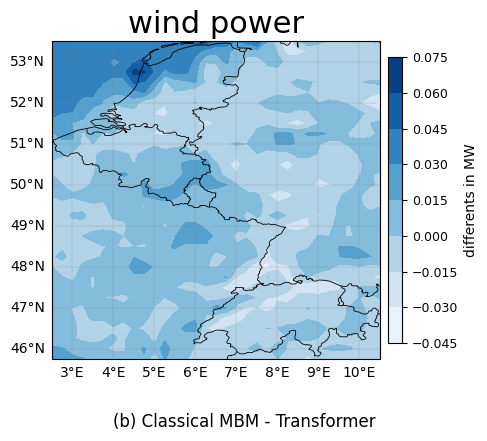

In [26]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = Tformer_one.longitude.values  # of .lon
lats = Tformer_one.latitude.values

TF_1 = wind_power_output_tf.mean(axis=0).mean(axis=(0, 1))
MBM_1 = wind_power_output_mbm.mean(axis=0).mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  MBM_1 - TF_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d, diff, cmap='Blues',transform=ccrs.PlateCarree())

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in MW', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.title('wind power', fontsize=22)
plt.figtext(0.5, -0.08, r"(b) Classical MBM - Transformer", fontsize=12, ha='center')

plt.tight_layout()
plt.show()

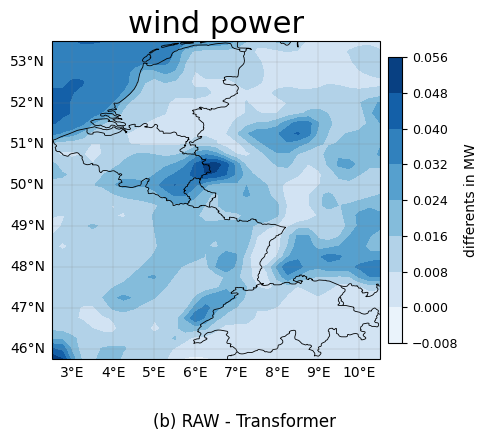

In [27]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = Tformer_one.longitude.values  # of .lon
lats = Tformer_one.latitude.values

TF_1 = wind_power_output_tf.mean(axis=0).mean(axis=(0, 1))
OG = wind_power_output_raw.mean(axis=0).mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  OG - TF_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d, diff, cmap='Blues',transform=ccrs.PlateCarree())

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in MW', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.title('wind power', fontsize=22)
plt.figtext(0.5, -0.08, r"(b) RAW - Transformer", fontsize=12, ha='center')

plt.tight_layout()
plt.show()